In [7]:
%pylab inline
import os
import astropy.io.fits as pyfits
import haloSim
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import astropy.table as astTab
#important constant
C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc
if True:
    figMsDir='/work/xiangchong.li/work/massMapSparse/sim/plot/'
else:
    figMsDir='/home/xiangchong/.local/code/massMap_Private/doc/paper_ms_method_HSCY1/'
    
plt.style.use('/home/xiangchong.li/.config/matplotlib/matplotlibrc_bf')

Populating the interactive namespace from numpy and matplotlib


/work/xiangchong.li/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Stamp Simulation 
(Based on WIDE12H tract 9347)


+ Make 100 realization of HSC-like shape noie, photo-z error
    + Understand how photo-z error change the lensing kernel
    + prepare both HSC-like mask and no mask simulations


+ Sample in ($M_h$, $z_h$) plane
    + For each ($M_h$, $z_h$) point adopt 100 noise realization 


+ Make 3D plot of simulated $\delta(z,\vec{\theta})$

In [2]:
tn='9347.fits'
pfn='datDir/S16AStandardCalibrated/tract/%s_pofz.fits' %tn.split('.')[0]
cfn='datDir/S16AStandardCalibrated/tract/%s' %tn
cdata=pyfits.getdata(cfn)
pdata=pyfits.getdata(pfn)['PDF']
assert len(pdata)==len(cdata)

## Masks

In [3]:
ra=cdata['coord_ra']*180/np.pi-np.average(cdata['coord_ra'])*180/np.pi
dec=cdata['coord_dec']*180/np.pi-np.average(cdata['coord_dec'])*180/np.pi
mask = (np.absolute(ra)<0.5) & (np.absolute(dec)<0.5)
cdata=cdata[mask]
pdata=pdata[mask]
ra=ra[mask]
dec=dec[mask]
ra2=np.random.rand(len(ra))-0.5
dec2=np.random.rand(len(dec))-0.5

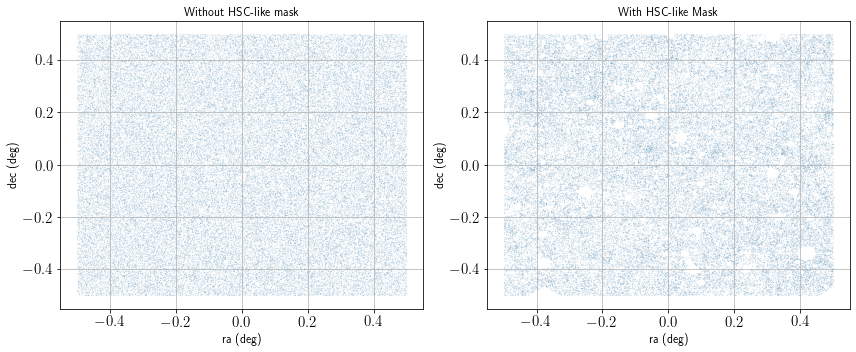

In [4]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.scatter(ra2,dec2,s=0.001)
ax.set_title('Without HSC-like mask')
ax.set_xlabel('ra (deg)',fontsize=12)
ax.set_ylabel('dec (deg)',fontsize=12)
plt.grid()
ax=fig.add_subplot(1,2,2)
ax.scatter(ra,dec,s=0.001)
ax.set_title('With HSC-like Mask')
ax.set_xlabel('ra (deg)',fontsize=12)
ax.set_ylabel('dec (deg)',fontsize=12)
plt.grid()
plt.tight_layout()

## Shape noise (error on shear)

+ We randomly rotate the ellipiticities of galaxies to mimic HSC shape noise.
+ We neglect the correlation of shape noise in this note.

In [14]:
def rotCatalog(e1, e2, phi=None):
    if phi  ==  None:
        phi = 2.0 * np.pi * np.random.rand(len(e1))
    cs = np.cos(phi)
    ss = np.sin(phi)
    e1_rot = e1 * cs + e2 * ss
    e2_rot = (-1.0) * e1 * ss + e2 * cs
    return e1_rot, e2_rot

from scipy.stats import norm
cmap=plt.get_cmap('tab20')

e1      =   cdata['ishape_hsm_regauss_e1']
e2      =   cdata['ishape_hsm_regauss_e2']
m_b     =   cdata['ishape_hsm_regauss_derived_shear_bias_m']
c1_b    =   cdata['ishape_hsm_regauss_derived_shear_bias_c1']
c2_b    =   cdata['ishape_hsm_regauss_derived_shear_bias_c2']
weight  =   cdata['ishape_hsm_regauss_derived_shape_weight']
w_A     =   np.sum(weight)
m_bA    =   np.sum(m_b*weight)/w_A
Res_A   =   1.-np.sum(cdata['ishape_hsm_regauss_derived_rms_e']**2.*weight)/w_A
g1      =   1./(1.+m_bA)*(e1/2./Res_A-c1_b)
g2      =   1./(1.+m_bA)*(e2/2./Res_A-c2_b)
t       =   1./(1.+m_bA)/2./Res_A
weight  =   weight/(t**2.)

g1nAll=[];g2nAll=[];wAll=[]
for itry in range(20):
    np.random.seed(itry)
    g1n,g2n =   rotCatalog(g1,g2)
    g1nAll.extend(g1n)
    g2nAll.extend(g2n)
    wAll.extend(weight)
    del g1n,g2n

g1pixAll=[]
for _i in range(100):
    g1pixAll.append(pyfits.getdata('wrkDir/sim/HSC-obs/20200328/pixes/pixShearR-g1-sim%s.fits' %_i)[:,24:72,24:72].flatten())
g1pixAll=np.hstack(g1pixAll)

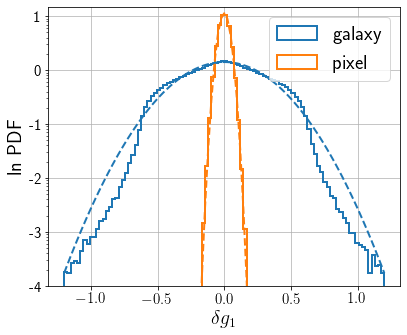

In [26]:
fig=plt.figure(figsize=(6,5))
ax=fig.add_subplot(1,1,1)

gbin=plt.hist(g1nAll,bins=100,density=True,range=(-1.2,1.2),
              histtype='step',linewidth=2.,label='galaxy',color=cmap(0))[1]
gbinGal=(gbin-np.average(g1nAll))/np.std(g1nAll)
a=norm.pdf(gbinGal)
ax.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(0),ls='--')

gbin=plt.hist(g1pixAll,bins=100,density=True,range=(-1.2,1.2),
              histtype='step',linewidth=2.,label='pixel',color=cmap(2))[1]
gbinPix=(gbin-np.average(g1pixAll))/np.std(g1pixAll)
a=norm.pdf(gbinPix)
ax.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')

#plt.title('HSC-like Shear Measurement Error',fontsize=20)
ax.set_xlabel(r'$\delta g_1$',fontsize=20)
ax.set_ylabel(r'ln PDF',fontsize=20)
ax.legend(fontsize=20,loc='upper right')
ax.set_yscale('log')
ax.set_yticks((1e-4,1e-3,1e-2,1e-1,1,10))
ax.set_yticklabels(('-4','-3','-2','-1','0','1'))
ax.set_ylim(1e-4,15)
ax.grid()
plt.tight_layout()
fig.savefig(os.path.join(figMsDir,'shapeMeasurementError-HSCY1.pdf'))

## Redshift
+ Photo-z PDF only depends on the redshift
+ Photo-z error are independent for any two different galaxies

$$g[s]=\sum_l g_{\infty}[l]\sum_{s'} K[l,s']P[s,s']$$

### $P[s,s']$

In [ ]:
bfn='datDir/S16AStandardV2/field/pz_pdf_bins_mlz.fits'
poz_bins=pyfits.getdata(bfn)['BINS']
pdfStack=   np.zeros((nbins,len(poz_bins)))
numStack=   np.zeros(nbins)
zBest=cdata['mlz_photoz_best']
for ip in range(nbins):
    mask    =   (zBest>slide_bins[ip])&(zBest<slide_bins[ip+1])
    dataMask=   pdata[mask]
    outData =   np.sum(dataMask,axis=0)
    pdfStack[ip]+=   outData
    numStack[ip]+=  np.sum(mask)
pdfAve=   pdfStack/numStack[:,None]
plt.figure(figsize=(8,6))
for pdf,zb in zip(pdfAve[0::5],zblist[0::5]):
    plt.plot(poz_bins,pdf,label=r'$z_{\rm{best}}=%.3f$' %zb)
plt.legend()
plt.xlim(-0.2,3)
plt.title("Photo-z PDF: P[s,s']",fontsize=15)
plt.xlabel('z',fontsize=15)
plt.ylabel('prob',fontsize=15)
plt.grid()

### $z_{\rm{best}}=1.825$
Galaxies at $z_{\rm{best}}=1.825$ but at different transverse positions.

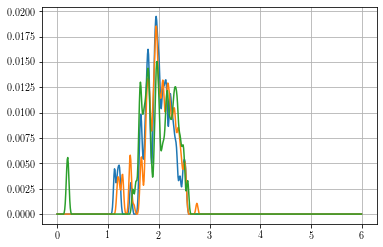

In [223]:
datau=pdata[(cdata['mlz_photoz_best']>1.95)& (cdata['mlz_photoz_best']<2.05)]
plt.plot(poz_bins,datau[0])
plt.plot(poz_bins,datau[1])
plt.plot(poz_bins,datau[4])
plt.grid()

### $K[l,s]$ vs.  $\sum_{s'} K[l,s']P[s,s']$

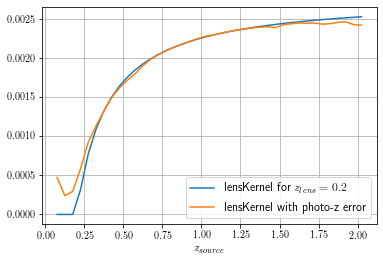

In [224]:
import cosmology
def four_pi_G_over_c_squared():
    # = 1.5*H0^2/roh_0/c^2
    # We want it return 4piG/c^2 in unit of Mpc/M_solar
    # in unit of m/kg
    fourpiGoverc2 = 4.0*np.pi*GNEWTON/(C_LIGHT**2)
    # in unit of pc/M_solar
    fourpiGoverc2 *= KG_PER_SUN/M_PER_PARSEC
    # in unit of Mpc/M_solar
    fourpiGoverc2 /= 1.e6
    return fourpiGoverc2
# Sigma_crit
cosmo=cosmology.Cosmo(h=1,omega_m=0.3)
z_l=0.2
z_s=zblist
k_s =   np.zeros(len(z_s))
mask=   z_s>z_l
k_s[mask] =   cosmo.Da(z_l,z_s[mask])*cosmo.Da(0.,z_l)/cosmo.Da(0.,z_s[mask])*four_pi_G_over_c_squared()
# Sigma_M_zl_bin
z_bin_min=z_l-0.05
z_bin_max=z_l+0.05
rhoM_ave=cosmo.rho_m((z_bin_min+z_bin_max)/2.)
DaBin=cosmo.Da(z_bin_min,z_bin_max)
lensKer=k_s*rhoM_ave*DaBin


cosmo=cosmology.Cosmo(h=1,omega_m=0.3)

z_s=poz_bins
k_s =   np.zeros(len(z_s))
mask=   z_s>z_l
k_s[mask] =   cosmo.Da(z_l,z_s[mask])*cosmo.Da(0.,z_l)/cosmo.Da(0.,z_s[mask])*four_pi_G_over_c_squared()
# Sigma_M_zl_bin
z_bin_min=z_l-0.05
z_bin_max=z_l+0.05
rhoM_ave=cosmo.rho_m((z_bin_min+z_bin_max)/2.)
DaBin=cosmo.Da(z_bin_min,z_bin_max)
lensKer1=k_s*rhoM_ave*DaBin
lensKerCov=np.zeros(len(zblist))
for ip in range(len(zblist)):
    lensKerCov[ip]=np.sum(pdfAve[ip]*lensKer1)
    
plt.plot(zblist,lensKer,label=r'lensKernel for $z_{lens}=0.2$')
plt.plot(zblist,lensKerCov,label='lensKernel with photo-z error')
plt.xlabel(r'$z_{source}$',fontsize=12)
plt.grid()
plt.legend(fontsize=12)

# Make 100 realizations

In [262]:
tableMock   =   astTab.Table()

g1nAll=[]
g2nAll=[]
raH=[]
decH=[]
raR=[]
decR=[]
ztrueAll=[]
zbestAll=[]

nobj, nbin = pdata.shape
pdata = pdata.astype(float)
pdata /= np.sum(pdata,axis=1).reshape(nobj, 1)
cdf = np.empty(shape=(nobj, nbin), dtype=float)
np.cumsum(pdata, axis=1, out=cdf)

nmock=100

for imock in range(nmock):
    tzmc  =   np.empty(nobj, dtype=float)
    np.random.seed(imock)
    # Monte Carlo z
    r     =   np.random.random(size=nobj)
    for i in range(nobj):
        tzmc[i] =   np.interp(r[i], cdf[i], poz_bins)
    np.random.seed(imock)
    g1n,g2n =   rotCatalog(g1,g2)
    g1nAll.extend(g1n)
    g2nAll.extend(g2n)
    raH.extend(ra)
    decH.extend(dec)
    raR.extend(ra2)
    decR.extend(dec2)
    ztrueAll.extend(tzmc)
    zbestAll.extend(zBest)

tableMock['g1n']  =   g1nAll
tableMock['g2n']  =   g2nAll
tableMock['zbest']  =   zbestAll
tableMock['ztrue']  =   ztrueAll
tableMock['raH']    =   raH
tableMock['decH']   =   decH
tableMock['raR']    =   raR
tableMock['decR']   =   decR

tableMock.write('wrkDir/stampSim/HSC-like/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits')

## Sanity Check photo-z error

(-0.01, 2.3)

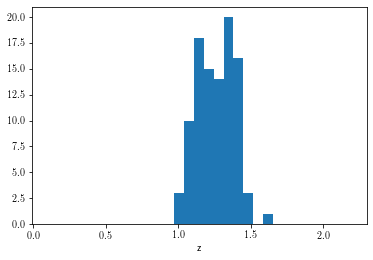

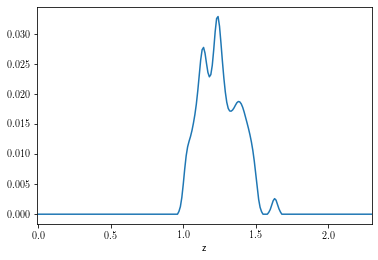

In [261]:
zshow=tableMock['ztrue'][100::82578]
plt.figure()
plt.hist(zshow)
plt.xlabel('z')
plt.xlim(-0.01,2.3)
plt.figure()
plt.plot(poz_bins,pdata[100])
plt.xlabel('z')
plt.xlim(-0.01,2.3)

# Simulate Halos with different ($M_h$ and $z_h$)

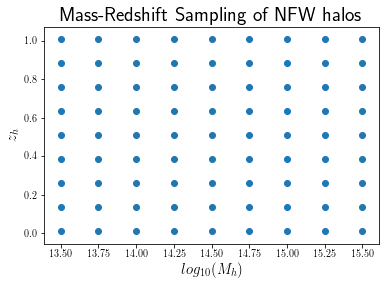

In [11]:
# (M_h, z_h) plane 
# 9 \times 9 sampling points
log_m_array=np.linspace(13.5,15.5,9)
z_array=np.linspace(0.01,1.01,9)
logM_grid,z_grid=np.meshgrid(log_m_array,z_array)
plt.scatter(logM_grid,z_grid)
plt.title('Mass-Redshift Sampling of NFW halos',fontsize=20)
plt.xlabel(r'$log_{10}(M_h)$',fontsize=15)
plt.ylabel(r'$z_{h}$',fontsize=15)
plt.savefig('../paper_ms_method_HSCY1/mass-redshift-sampling.pdf')

## WB00 untruncated halo simulation

In [ ]:
if False:
    # Read the HSC-like shape noise photo-z error
    tableMock=astTab.Table.read('wrkDir/stampSim/HSC-like/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits')

num=len(tableMock)//100
for iz,z_h in enumerate(z_array):
    for im,log_m in enumerate(log_m_array):
        tab=tableMock.copy()
        M_200=   10.**(log_m)
        conc =   6.02*(M_200/1.E13)**(-0.12)*(1.47/(1.+z_h))**(0.16)
        halo =   haloSim.nfw_lensWB00(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)
        lensKer= halo.lensKernel(tab['ztrue'])
        shearR=  np.tile(halo.DeltaSigmaComplex(tab['raR'].data[:num]*3600.,tab['decR'].data[:num]*3600.),100)*lensKer
        shearH=  np.tile(halo.DeltaSigmaComplex(tab['raH'].data[:num]*3600.,tab['decH'].data[:num]*3600.),100)*lensKer
        tab['g1R']=shearR.real
        tab['g2R']=shearR.imag
        tab['g1H']=shearH.real
        tab['g2H']=shearH.imag
        tab.write('wrkDir/stampSim/HSC-like/stampSim-HSC_like-%d,%d-202003312131.fits' %(iz,im))
        del tab

In [11]:
# Add column weights
weightA=np.tile(weight,100)
for iz in range(9):
    for im in range(9):
        fname='wrkDir/stampSim/HSC-like/stampSim-HSC_like-%d,%d-202003312131.fits' %(iz,im)
        tab=astTab.Table.read(fname)
        tab['weights']=weightA
        tab.write(fname,overwrite=True)

## TJ03 truncated halo simulation

In [ ]:
if True:
    tableMock=astTab.Table.read('wrkDir/stampSim/HSC-like/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits')

num=len(tableMock)//100
for iz,z_h in enumerate(z_array):
    for im,log_m in enumerate(log_m_array):
        tab=tableMock.copy()
        M_200=   10.**(log_m)
        conc =   6.02*(M_200/1.E13)**(-0.12)*(1.47/(1.+z_h))**(0.16)
        halo =   haloSim.nfw_lensTJ03(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)
        lensKer= halo.lensKernel(tab['ztrue'])
        shearR=  np.tile(halo.DeltaSigmaComplex(tab['raR'].data[:num]*3600.,tab['decR'].data[:num]*3600.),100)*lensKer
        shearH=  np.tile(halo.DeltaSigmaComplex(tab['raH'].data[:num]*3600.,tab['decH'].data[:num]*3600.),100)*lensKer
        tab['g1R']=shearR.real
        tab['g2R']=shearR.imag
        tab['g1H']=shearH.real
        tab['g2H']=shearH.imag
        tab.write('wrkDir/stampSim/HSC-like/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im))
        del tab

In [10]:
# Add column weights
weightA=np.tile(weight,100)
for iz in range(9):
    for im in range(9):
        fname='wrkDir/stampSim/HSC-like/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im)
        tab=astTab.Table.read(fname)
        tab['weights']=weightA
        tab.write(fname,overwrite=True)

In [33]:
log_m_array=np.linspace(13.5,15.5,9)
z_array=np.linspace(0.01,1.01,9)
names=('iz','im','zh','log10_M200','conc','rs_arcmin')
data=[]
for iz,z_h in enumerate(z_array):
    for im,log_m in enumerate(log_m_array):
        M_200=   10.**(log_m)
        conc =   6.02*(M_200/1.E13)**(-0.12)*(1.47/(1.+z_h))**(0.16)
        halo =   haloSim.nfw_lensTJ03(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)
        rs_amin=halo.rs_arcsec/60.
        data.append((iz,im,z_h,log_m,conc,rs_amin))
tabOut=astTab.Table(rows=data,names=names)
tabOut.write('wrkDir/stampSim/HSC-like/haloCat.csv')

## Visualize the shear map

In [10]:
cd wrkDir/

/lustre2/work/xiangchong.li/massMapSim


In [49]:
import astropy.io.fits as pyfits
from configparser import ConfigParser
from pixel3D import cartesianGrid3D

ngroup  =   100
raname  =   'raR'
decname =   'decR'
zname   =   'zbest'
g1name  =   'g1R'
g2name  =   'g2R'

configName  =   'stampSim/HSC-like/process-equalNum10/config.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)

im  =   4
iz  =   4

infname =   'stampSim/HSC-like/sims/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im)
datTab  =   pyfits.getdata(infname)
ng=len(datTab)//ngroup

ig=0
datU=datTab[ig*ng:(ig+1)*ng]
val=datU[g1name]+datU[g2name]*1j
outcome0=gridInfo.pixelize_data(datU[raname],datU[decname],datU[zname],val)

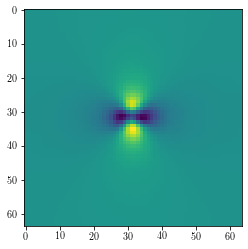

In [60]:
plt.imshow(outcome0.real[4])

In [39]:
ngroup  =   100
raname  =   'raR'
decname =   'decR'
zname   =   'ztrue'
g1name  =   'g1R'
g2name  =   'g2R'

configName  =   'stampSim/HSC-like/process-equalNum10/config.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)

im  =   4
iz  =   4

infname =   'stampSim/HSC-like/sims/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im)
datTab  =   pyfits.getdata(infname)
ng=len(datTab)//ngroup

ig=0
datU=datTab[ig*ng:(ig+1)*ng]
val=datU[g1name]+datU[g2name]*1j
outcome=gridInfo.pixelize_data(datU[raname],datU[decname],datU[zname],val)

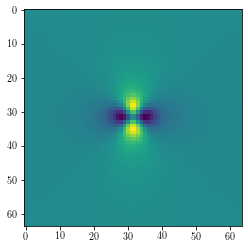

In [62]:
plt.imshow(outcome.real[6])

In [55]:
for i in range(10):
    print(np.abs(outcome.real[i]).max(),np.abs(outcome0.real[i]).max())

0.0 0.0034117309861092086
0.0 0.004744804073098185
0.0007868479365185639 0.003421684138931673
0.006441113965353803 0.0052999197037006136
0.009443334988526739 0.009400605888999502
0.013296199250073394 0.012794669701238338
0.01480261424964752 0.014380770724708388
0.017986256881912875 0.017051756506035187
0.021751935139905473 0.020287041598120774
0.02495454295613837 0.025518535018767642
